In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Word2Vec
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [2]:
ddd = pd.read_csv('train.csv')
ddd['comment_text'] = ddd['comment_text'].str.lower()
ddd['comment_text'] = ddd['comment_text'].str.replace(r"[^a-z\']", ' ', regex=True).str.split()

In [3]:
ddd

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"[explanation, why, the, edits, made, under, my...",0,0,0,0,0,0
1,000103f0d9cfb60f,"[d'aww, he, matches, this, background, colour,...",0,0,0,0,0,0
2,000113f07ec002fd,"[hey, man, i'm, really, not, trying, to, edit,...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"[more, i, can't, make, any, real, suggestions,...",0,0,0,0,0,0
4,0001d958c54c6e35,"[you, sir, are, my, hero, any, chance, you, re...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,"[and, for, the, second, time, of, asking, when...",0,0,0,0,0,0
159567,ffea4adeee384e90,"[you, should, be, ashamed, of, yourself, that,...",0,0,0,0,0,0
159568,ffee36eab5c267c9,"[spitzer, umm, theres, no, actual, article, fo...",0,0,0,0,0,0
159569,fff125370e4aaaf3,"[and, it, looks, like, it, was, actually, you,...",0,0,0,0,0,0


In [4]:
df = spark.createDataFrame(ddd)

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [5]:
df.take(5)

[Row(id='0000997932d777bf', comment_text=['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', "weren't", 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', "don't", 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', "i'm", 'retired', 'now'], toxic=0, severe_toxic=0, obscene=0, threat=0, insult=0, identity_hate=0),
 Row(id='000103f0d9cfb60f', comment_text=["d'aww", 'he', 'matches', 'this', 'background', 'colour', "i'm", 'seemingly', 'stuck', 'with', 'thanks', 'talk', 'january', 'utc'], toxic=0, severe_toxic=0, obscene=0, threat=0, insult=0, identity_hate=0),
 Row(id='000113f07ec002fd', comment_text=['hey', 'man', "i'm", 'really', 'not', 'trying', 'to', 'edit', 'war', "it's", 'just', 'that', 'this', 'guy', 'is', 'constantly', 'removing', 'relevant', 'information', 'and', 'talking', 'to', 'me', 'through', 'edits'

hashingTF-IDF

In [6]:
num_fs = [3, 5, 7, 10]
categories = 'toxic' , 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
res_idf = {cat: [] for cat in categories}
for numFeatures in num_fs:
    for category in categories:
        hashingTF = HashingTF(inputCol="comment_text", outputCol="rawFeatures", numFeatures=numFeatures)
        featurizedData = hashingTF.transform(df)
        idf = IDF(inputCol="rawFeatures", outputCol="features")
        idfModel = idf.fit(featurizedData)
        rescaled_data = idfModel.transform(featurizedData)
        lr = LogisticRegression(featuresCol='rawFeatures', labelCol=category)
        evaluator = BinaryClassificationEvaluator(labelCol=category)
        grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
        cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,  parallelism=4)
        cvModel = cv.fit(rescaled_data)
        res_idf[category].append(cvModel.avgMetrics[1])

Text(0, 0.5, 'metric')

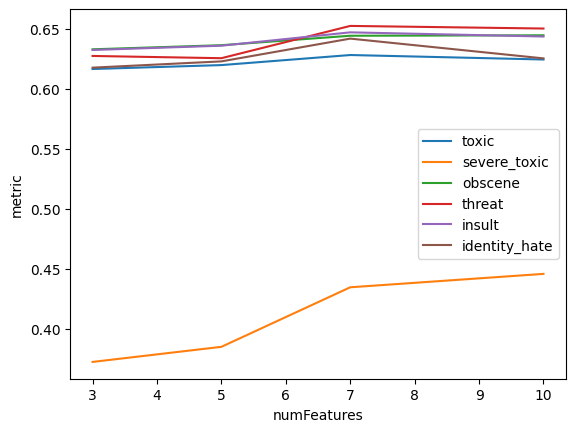

In [7]:
for category in categories:
    plt.plot(num_fs, res_idf[category])
plt.legend(categories)
plt.xlabel('numFeatures')
plt.ylabel('metric')

Word2Vec

In [8]:
sizes = [3, 5, 7, 10]
categories = 'toxic' , 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
res_w2v = {cat: [] for cat in categories}
for size in sizes:
    for category in categories:
        word2Vec = Word2Vec(vectorSize=size, minCount=0, inputCol="comment_text", outputCol="Word2Vec")
        model = word2Vec.fit(df)
        result = model.transform(df)
        lr = LogisticRegression(featuresCol='Word2Vec', labelCol=category)
        evaluator = BinaryClassificationEvaluator(labelCol=category)
        grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
        cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,  parallelism=4)
        cvModel = cv.fit(result)
        res_w2v[category].append(cvModel.avgMetrics[1])


Text(0, 0.5, 'metric')

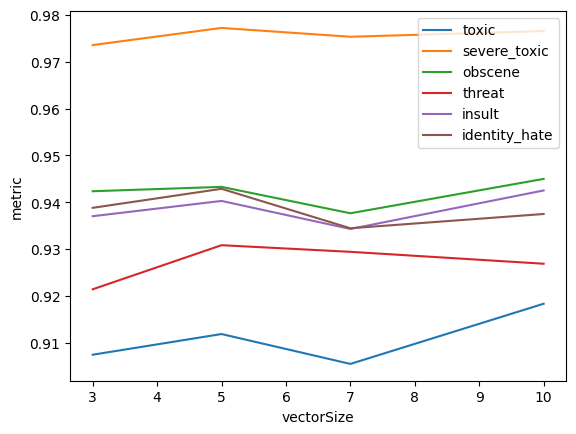

In [9]:
for category in categories:
    plt.plot(sizes, res_w2v[category])
plt.legend(categories)
plt.xlabel('vectorSize')
plt.ylabel('metric')